# Imports 

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import igraph as ig
import leidenalg
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import itertools
import joblib
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from functions import (generate_param_combinations, model_tuning, train_tuned_model, train_final_model)

import pickle
from geneformer import Classifier

# Data Exploration

In [ ]:
warnings.filterwarnings("ignore")

# Configuration
EXPRESSION_FILE = 'functional_thymus_fully_preprocessed.csv'
HVGS_FILE = 'functional_thymus_HVGs.txt'
OUTPUT_DIR = 'gene_classification'

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: {OUTPUT_DIR}")

# Configure Scanpy for plot saving
# This tells scanpy to save all figures into our specified OUTPUT_DIR
sc.settings.figdir = OUTPUT_DIR
sc.settings.set_figure_params(dpi=100, facecolor='white') # Set default figure parameters

### Distinguish High Variable Genes

We load the gene expression matrix from the CSV file provided, with genes as rows and samples (single cells) as columns [Loaded expression data. Shape: (26874, 10281)]. We transpose the matrix to fir AnnData's format: cells x genes [AnnData object created. Shape: (10281, 26874) (Cells x Genes)]. We also load the list that contains 2033 highly variable genes (HVGs) from the text file provided. 

In [ ]:
# Load Data
print(f"--- Step 1: Loading Data ---")
try:
    # Load the gene expression table
    # genes are in the index and cells/samples are in the columns
    expression_df = pd.read_csv(EXPRESSION_FILE, index_col=0)
    print(f"Loaded expression data. Shape: {expression_df.shape}")
    # Transpose the matrix to have cells as rows and genes as columns, which is the standard format for scanpy's AnnData object
    adata = sc.AnnData(expression_df.T)
    print(f"AnnData object created. Shape: {adata.shape} (Cells x Genes)")

    # Load the highly variable genes (HVGs) list
    with open(HVGS_FILE, 'r') as f:
        hvg_genes = []
        for line in f:
            stripped_line = line.strip()
            if stripped_line:
                # Remove leading numbers and dots (e.g., "1.ENSG..." -> "ENSG...")
                if '.' in stripped_line and stripped_line.split('.', 1)[0].isdigit():
                    hvg_genes.append(stripped_line.split('.', 1)[1])
                else:
                    hvg_genes.append(stripped_line)
    print(f"Loaded {len(hvg_genes)} highly variable genes.")

except FileNotFoundError:
    print(f"Error: Make sure '{EXPRESSION_FILE}' and '{HVGS_FILE}' are in the same directory as the script.")
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit()

In [ ]:
# To save as .h5ad format
h5ad_output_path = os.path.join(OUTPUT_DIR, 'pre-processed_data.h5ad')
adata.write(h5ad_output_path)
print(f"Data saved to {h5ad_output_path}")

We filter by HVG, by identifying the intersection of HVGs and the genes in the dataset and we subset the dataset to retain only those HVGs. We annotate the retained genes as highly variable. 

In [ ]:
# Filter by Highly Variable Genes
print(f"\n--- Step 2: Filtering by Highly Variable Genes ---")
# Ensure the HVG list only contains genes present in the AnnData object's var_names (gene names)
common_hvgs = [gene for gene in hvg_genes if gene in adata.var_names]

if not common_hvgs:
    print("Warning: No highly variable genes from the provided list were found in the expression table.")
    print("Proceeding without HVG filtering. Please check if gene identifiers match.")

else:
    print(f"Found {len(common_hvgs)} HVGs present in the dataset.")
    # Create a boolean mask for HVGs
    adata.var['highly_variable'] = adata.var_names.isin(common_hvgs)
    # Subset the AnnData object to keep only highly variable genes
    adata = adata[:, adata.var['highly_variable']]
    print(f"AnnData object filtered to {adata.shape[1]} highly variable genes. Shape: {adata.shape} (Cells x Genes)")

Since the provided data has already been preprocessed, normalization and log-transformation are skipped, but the remaining preprocessing steps such as Scaling and Dimensionality Reduction by applying PCA are performed nonetheless. 

In [ ]:
# Normalization and Log-transformation (already done)
# sc.pp.normalize_total(adata, target_sum=1e6) # CPM normalization
# sc.pp.log1p(adata) # log(x+1) transformation
print(f"\n--- Step 3: Skipping Normalization and Log-transformation (already preprocessed) ---")

In [ ]:
# Scaling the Data 
# Scaling ensures that highly expressed genes don't dominate the PCA.
print(f"\n--- Step 4: Scaling Data ---")
sc.pp.scale(adata, max_value=10) # Clip values at 10 to avoid extreme outliers
print("Data scaled.")

In [ ]:
# Dimensionality Reduction (PCA) 
print(f"\n--- Step 5: Performing Principal Component Analysis (PCA) ---")
sc.tl.pca(adata, svd_solver='arpack')
print("PCA completed.")

# Plot PCA (will be saved to OUTPUT_DIR)
sc.pl.pca(adata, show=False, save='pca_plot.png')
print(f"PCA plot saved to {os.path.join(OUTPUT_DIR, 'pca_plot.png')}")

### Save Data for Classifiers

In [ ]:
h5ad_output_path = os.path.join(OUTPUT_DIR, 'processed_data.h5ad')
adata.write(h5ad_output_path)
print(f"Data saved to {h5ad_output_path}")

In [ ]:
print(f"AnnData object filtered to {adata.shape[1]} highly variable genes. Shape: {adata.shape} (Cells x Genes)")

## Add Labels: Dosage Sensitivity 

We prepare our data for the gene-level binary classification task using dosage sensitvity annotations. We load the precompiled python pickle file containing a dictionary with 2 keys: "Dosage-sensitive TFs", list of Ensembl gene IDs labeled as Dosage-sensitive (label=1) and "Dosage-insensitive TFs", list of Ensembl gene IDs labeled as dosage-insensitive (label=0). After loading the expression matrix, which now has shape cellsxgenes (10281x2033), we transpose it again because for this task we want each gene to become a sample and each cell to become a feature, enabling gene-level classification. A new AnnData object is created where: .X contains gene expression profiles across cells, .obs contains gene metadata, .var contains cell metadata. Finally, we build a Gene Label Dataframe that assigns label 1 to dosage sensitive genes, label 0 to dosage insensitive genes. 

In [ ]:
# Download the pre‐built gene→[gene_list] dict 
pickle_path = "/home/user_stel/AIMB/Genecorpus-30M/example_input_files/gene_classification/dosage_sensitive_tfs/dosage_sensitivity_TFs.pickle"

# Load it
with open(pickle_path, "rb") as f:
    gene_class_dict = pickle.load(f)

print(gene_class_dict)

In [ ]:
adata = sc.read_h5ad("/home/user_stel/AIMB/gene_classification/processed_data.h5ad")
print(f"AnnData object shape: {adata.shape} (Cells x Genes)")

X_transposed = adata.X.T  # Shape will be (2033, 10281)

# Create a new AnnData object with genes as rows
adata_genes = sc.AnnData(
    X=X_transposed,
    obs=adata.var.copy(),   # Now genes are the observations
    var=adata.obs.copy()    # Cells become the variables
)

print(f"AnnData object transposed shape: {X_transposed.shape} (Genes x Cells)")

In [ ]:
# Creat Label Dataframe
df_sensitive = pd.DataFrame({"ensembl_id": gene_class_dict["Dosage-sensitive TFs"], "label": 1})
df_insensitive = pd.DataFrame({"ensembl_id": gene_class_dict["Dosage-insensitive TFs"], "label": 0})
df_labels = pd.concat([df_sensitive, df_insensitive], ignore_index=True)

We perform a left joint between adata_genes.obs and sf_labels on "ensembl_id" and we add a new column "label" to adata_genes.obs: 1 for dosage-sensitive, 0 for dosage-insensitive and NaN for genes not found in the classification dictionary. 

In [ ]:
# make sure the index (gene IDs) is a column with the correct name
adata_genes.obs["ensembl_id"] = adata_genes.obs.index.astype(str)

# ensure df_labels has string IDs
df_labels["ensembl_id"] = df_labels["ensembl_id"].astype(str)

# merge labels into obs
adata_genes.obs = adata_genes.obs.merge(df_labels, on="ensembl_id", how="left")

# set ensembl_id as index again
adata_genes.obs = adata_genes.obs.set_index("ensembl_id")

In [ ]:
print(adata_genes.obs["label"].value_counts(dropna=False))
print(adata_genes.obs)

### Save Labeled Data

In [ ]:
print(adata_genes)
h5ad_output_path = os.path.join(OUTPUT_DIR, 'labeled_data.h5ad')
adata_genes.write(h5ad_output_path)
print(f"Data saved to {h5ad_output_path}")

# Load Data 

Data for Other Classifiers

In [ ]:
adata_genes = sc.read_h5ad("labeled_data.h5ad")
print(f"AnnData object Shape: {adata_genes.shape} (Genes x Cells)")

# Gene Classification via Geneformer

In [2]:
OUTPUT_DIR = '../gene_classification_results'

# Create output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    print(f"Created output directory: {OUTPUT_DIR}")

output_prefix = "tf_dosage_sens_test"
output_dir = f"../gene_classification_results"

In [3]:
pickle_path = "../data/dosage_sensitivity_TFs.pickle"

# Load it
with open(pickle_path, "rb") as f:
    gene_class_dict = pickle.load(f)

print(gene_class_dict)

type(gene_class_dict)

{'Dosage-sensitive TFs': ['ENSG00000008197', 'ENSG00000008441', 'ENSG00000010818', 'ENSG00000011332', 'ENSG00000030419', 'ENSG00000062194', 'ENSG00000065970', 'ENSG00000067082', 'ENSG00000069667', 'ENSG00000072736', 'ENSG00000073282', 'ENSG00000073861', 'ENSG00000077092', 'ENSG00000083307', 'ENSG00000084676', 'ENSG00000085276', 'ENSG00000087510', 'ENSG00000087903', 'ENSG00000089225', 'ENSG00000091656', 'ENSG00000091831', 'ENSG00000095951', 'ENSG00000100644', 'ENSG00000100968', 'ENSG00000101076', 'ENSG00000101412', 'ENSG00000102870', 'ENSG00000102935', 'ENSG00000103449', 'ENSG00000105698', 'ENSG00000105866', 'ENSG00000106689', 'ENSG00000106852', 'ENSG00000111249', 'ENSG00000111783', 'ENSG00000112033', 'ENSG00000112246', 'ENSG00000112561', 'ENSG00000112837', 'ENSG00000115112', 'ENSG00000116809', 'ENSG00000116833', 'ENSG00000117000', 'ENSG00000118263', 'ENSG00000118922', 'ENSG00000119547', 'ENSG00000120798', 'ENSG00000121068', 'ENSG00000123358', 'ENSG00000123411', 'ENSG00000124496', 'ENSG

dict

In [4]:
cc = Classifier(classifier="gene",
                gene_class_dict = gene_class_dict,
                max_ncells = 10_000,
                freeze_layers = 4,
                num_crossval_splits = 5,
                forward_batch_size=200,
                nproc=95)

Hyperparameter tuning is highly recommended for optimal results. No training_args provided; using default hyperparameters. Please note: these defaults are not recommended to be used uniformly across tasks.
Genes to classify ['ENSG00000177946', 'ENSG00000249459', 'ENSG00000214189', 'ENSG00000215271', 'ENSG00000196381'] are not in token dictionary.


In [5]:
cc.prepare_data(
    input_data_file="../data/tokenized_data/ht_for_geneformer.dataset",
    output_directory=output_dir,
    output_prefix=output_prefix,
    split_id_dict=None,
)

In [6]:
import os
os.environ["WANDB_DISABLED"] = "true"

all_metrics = cc.validate(model_directory="../model/Geneformer/gf-12L-95M-i4096",
                          prepared_input_data_file=f"{output_dir}/{output_prefix}_labeled.dataset",
                          id_class_dict_file=f"{output_dir}/{output_prefix}_id_class_dict.pkl",
                          output_directory=output_dir,
                          output_prefix=output_prefix)

mkdir: cannot create directory ‘../gene_classification_results/250720_geneformer_geneClassifier_tf_dosage_sens_test/’: File exists


0it [00:00, ?it/s]

****** Validation split: 1/5 ******



Some weights of BertForTokenClassification were not initialized from the model checkpoint at ../model/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
83,0.298200
166,0.043100
249,0.016300
332,0.009400
415,0.007200


  0%|          | 0/46 [00:00<?, ?it/s]

****** Validation split: 2/5 ******



Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/9659 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9659 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/9107 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9107 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ../model/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
83,0.292300
166,0.041600
249,0.013800
332,0.009400
415,0.007300


  0%|          | 0/49 [00:00<?, ?it/s]

****** Validation split: 3/5 ******



Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/9203 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9203 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/9092 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9092 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ../model/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
83,0.289500
166,0.040600
249,0.015800
332,0.009600
415,0.007900


  0%|          | 0/47 [00:00<?, ?it/s]

****** Validation split: 4/5 ******



Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/9017 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9017 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/9810 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/9810 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ../model/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
83,0.287300
166,0.041200
249,0.013000
332,0.008000
415,0.007600


  0%|          | 0/46 [00:00<?, ?it/s]

****** Validation split: 5/5 ******



Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=95):   0%|          | 0/11164 [00:00<?, ? examples/s]

Map (num_proc=95):   0%|          | 0/8653 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8653 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ../model/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
83,0.280000
166,0.039600
249,0.012900
332,0.009200
415,0.006700


  0%|          | 0/50 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

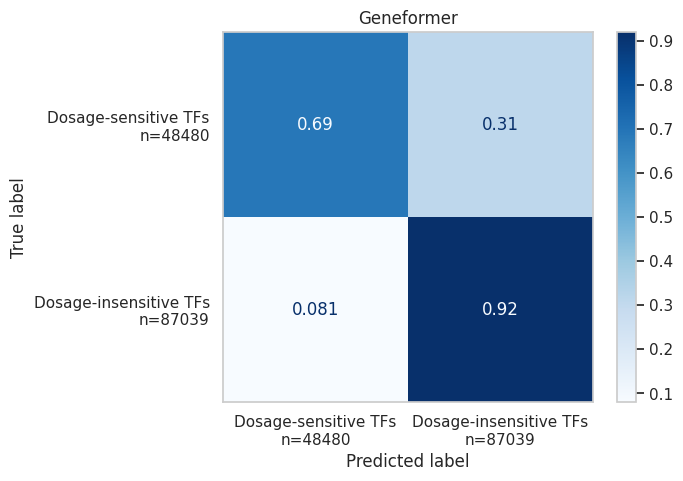

In [7]:
cc.plot_conf_mat(
    conf_mat_dict={"Geneformer": all_metrics["conf_matrix"]},
    output_directory=output_dir,
    output_prefix=output_prefix,
)

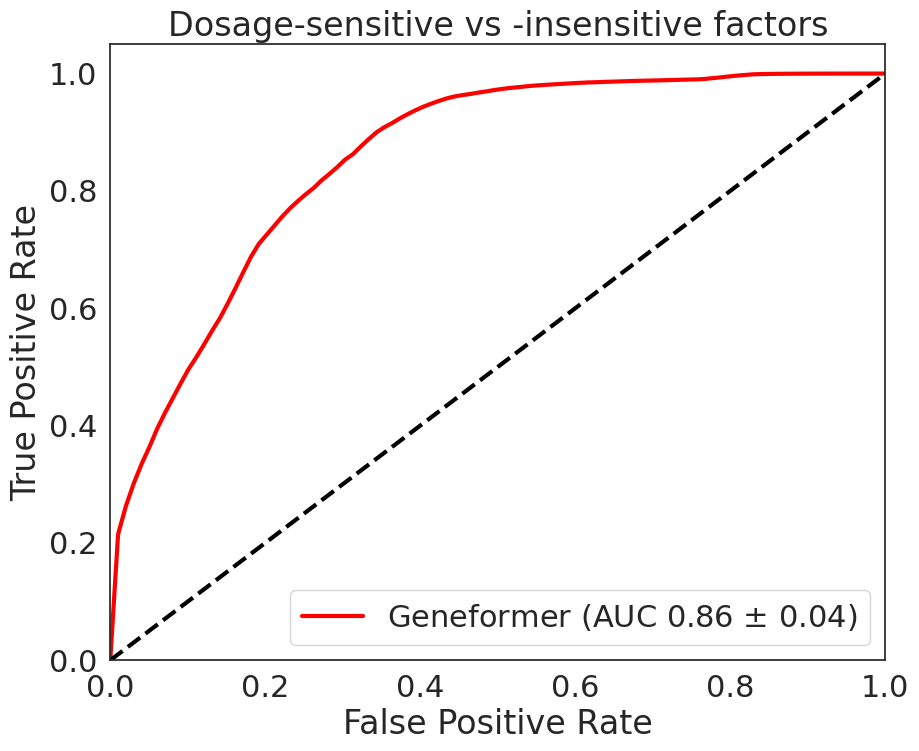

In [8]:
cc.plot_roc(
    roc_metric_dict={"Geneformer": all_metrics["all_roc_metrics"]},
    model_style_dict={"Geneformer": {"color": "red", "linestyle": "-"}},
    title="Dosage-sensitive vs -insensitive factors",
    output_directory=output_dir,
    output_prefix=output_prefix,
)

# Semi-Supervised Gene Classification

## Self-Training 

We implement a self-training semi-supervised learning approach to classify genes as dosage-sensitive or insensitive based on their expression profiles across all cells. X: Matrix of gene expression values where each row is a gene and each column is a cell [shape (2033 × 10281)], y: Label vector for each gene. A RandomForestClassifier is used as the base learner and wrapped in a SelfTrainingClassifier which: iteratively predicts pseudo-labels for unlabeled samples, adds them to the training set if the prediction confidence exceeds 0.8, continues training until convergence or no more pseudo-labels are added. 

In [3]:
# Self-Training 

# Features: gene expression across all cells
X = adata_genes.X  # (genes x cells)
y = adata_genes.obs["label"].fillna(-1).astype(int).values

from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier

# Base classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Self-training wrapper
self_training_clf = SelfTrainingClassifier(clf, threshold=0.8, verbose=True)

# Fit the model
self_training_clf.fit(X, y)

End of iteration 1, added 202 new labels.
End of iteration 2, added 844 new labels.
End of iteration 3, added 364 new labels.
End of iteration 4, added 77 new labels.
End of iteration 5, added 9 new labels.
End of iteration 6, added 3 new labels.
End of iteration 7, added 3 new labels.
End of iteration 8, added 2 new labels.
End of iteration 9, added 1 new labels.


SelfTrainingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                       threshold=0.8, verbose=True)

## Predict labels for the unlabeled data 

In [4]:
# Fill Anndata with the Predicted Labels

# Final predicted labels for all genes
adata_genes.obs["label_propagated"] = self_training_clf.predict(X)

# Confidence scores
probs = self_training_clf.predict_proba(X)
adata_genes.obs["confidence"] = np.max(probs, axis=1)

# Boolean mask for inferred labels
adata_genes.obs["was_inferred"] = adata_genes.obs["label"].isna()

### Save Propagated Dataset

In [ ]:
gene_classification = "/home/user_stel/AIMB/gene_classification"
h5ad_output_path = os.path.join(gene_classification, "propagated_data.h5ad")
adata_genes.write(h5ad_output_path)
print(f"Data saved to {h5ad_output_path}")

## Class Imbalance and Separability 

/tmp/ipykernel_14903/2200391866.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=adata_genes.obs, x="label_propagated", palette="Oranges")


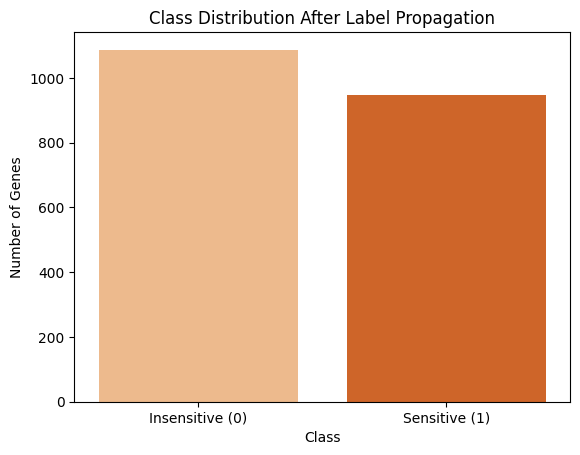

In [ ]:
# Use the propagated labels
sns.countplot(data=adata_genes.obs, x="label_propagated", palette="Oranges")
plt.title("Class Distribution After Label Propagation")
plt.xlabel("Class")
plt.ylabel("Number of Genes")
plt.xticks([0, 1], ["Sensitive (0)", "Insensitive (1)"])
plt.show()

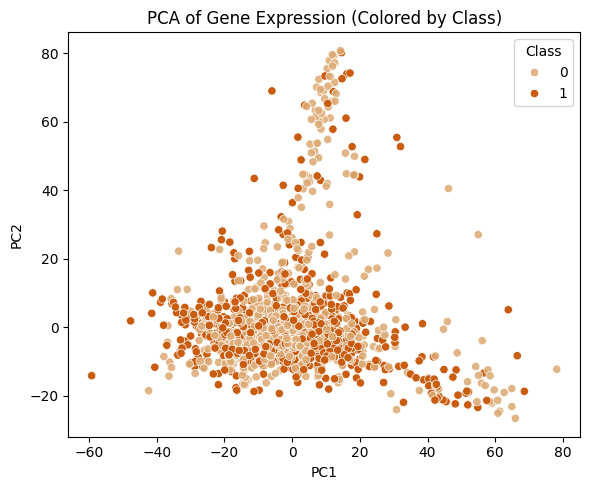

In [ ]:
X = adata_genes.X
y = adata_genes.obs["label_propagated"]

# Reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray() if hasattr(X, "toarray") else X)

# Plot
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette=["#DDAA73DE", "#C95C0E"])
plt.title("PCA of Gene Expression (Colored by Class)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Class")
plt.tight_layout()
plt.show()


## Hyperparameter Tuning

We define the 5 models for comparison along with their hyperparameter grids and we prepare features and labels as such: X: gene expression across all cells (genes × cells), y: binary labels (label_propagated) for each gene from the self-training classifier

In [3]:
adata_genes = sc.read_h5ad("/home/user_stel/AIMB/gene_classification/propagated_data.h5ad")
print(f"AnnData object Shape: {adata_genes.shape} (Genes x Cells)")

models = {
    'LogisticRegression-elasticnet': LogisticRegression,
    'GaussianNB': GaussianNB,
    'SVC': SVC,
    'RandomForest': RandomForestClassifier,
    'XGBoost': XGBClassifier
}


param_grid = {
    'LogisticRegression-elasticnet': {
        'C': [0.01, 0.1, 1, 10],
        'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
    },
    'GaussianNB': {
        'var_smoothing': np.logspace(-9, -1, 9)
    },
    'SVC': [
        {'kernel': ['linear'], 'C': [0.1, 1, 10]},
        {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.01, 0.1]}
    ],
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'XGBoost': {
        'n_estimators': [100],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

X = adata_genes.X
y = adata_genes.obs["label_propagated"]

AnnData object Shape: (2033, 10281) (Genes x Cells)


In [11]:
# Methods 
def generate_param_combinations(param_grid):
    combos = []
    # ensure we have a list of grids
    if isinstance(param_grid, list): 
        grids = param_grid 
    else:
        grids = [param_grid]

    for grid in grids:
        keys, values = zip(*grid.items())
        for vals in itertools.product(*values):
            combos.append(dict(zip(keys, vals)))

    return combos

def model_tuning(model, X, y, param_grid, cv):
    best_auc    = 0.0
    best_model  = None
    best_params = None
    model_name  = model.__name__ if isinstance(model, type) else model.__class__.__name__

    combos = generate_param_combinations(param_grid)

    # now just loop over that list
    for combo_dict in combos:
        model_instance = model(**combo_dict)
        scores = cross_val_score(
            model_instance,
            X, y,
            scoring='roc_auc',
            cv=cv
        )
        auc = scores.mean()

        print(f"[{model_name}] Tested params: {combo_dict}")
        print(f"[{model_name}] AUC: {auc:.4f}")

        # keep this check *inside* the combo loop
        if auc > best_auc:
            best_auc    = auc
            best_model  = model_instance
            best_params = combo_dict
            print(f"[{model_name}] New best AUC: {best_auc:.4f}")
            print(f"[{model_name}] Best params so far: {best_params}")
    
    return {
        'Best AUC':    best_auc,
        'Best Model':  best_model,
        'Best Params': best_params
    }

In [14]:
warnings.filterwarnings("ignore")

for name, model_class in models.items():
    print(f"\nRunning tuning for {name}")
    grid = param_grid[name]
    results = model_tuning(model=model_class, X=X, y=y, param_grid=grid, cv=5)


Running tuning for LogisticRegression-elasticnet
[LogisticRegression] Tested params: {'C': 0.01, 'l1_ratio': 0.0}
[LogisticRegression] AUC: 0.7128
[LogisticRegression] New best AUC: 0.7128
[LogisticRegression] Best params so far: {'C': 0.01, 'l1_ratio': 0.0}
[LogisticRegression] Tested params: {'C': 0.01, 'l1_ratio': 0.25}
[LogisticRegression] AUC: 0.7128
[LogisticRegression] Tested params: {'C': 0.01, 'l1_ratio': 0.5}
[LogisticRegression] AUC: 0.7128
[LogisticRegression] Tested params: {'C': 0.01, 'l1_ratio': 0.75}
[LogisticRegression] AUC: 0.7128
[LogisticRegression] Tested params: {'C': 0.01, 'l1_ratio': 1.0}
[LogisticRegression] AUC: 0.7128
[LogisticRegression] Tested params: {'C': 0.1, 'l1_ratio': 0.0}
[LogisticRegression] AUC: 0.7036
[LogisticRegression] Tested params: {'C': 0.1, 'l1_ratio': 0.25}
[LogisticRegression] AUC: 0.7036
[LogisticRegression] Tested params: {'C': 0.1, 'l1_ratio': 0.5}
[LogisticRegression] AUC: 0.7036
[LogisticRegression] Tested params: {'C': 0.1, 'l1_rat

#### Save Hyperparameter results because tuning took 857min

In [18]:
joblib.dump(results, "tuning_results.pkl")
print("All hyperparameter tuning results saved.")

All hyperparameter tuning results saved.


In [ ]:
# # Results Summary (only for visualization purposes)
# summary_data = [
#     {
#         "Model": "Logistic Regression",
#         "Best AUC": 0.7128,
#         "Best Param Combo": "C=0.01, l1_ratio=0.0"
#     },
#     {
#         "Model": "Gaussian Naïve Bayes",
#         "Best AUC": 0.6714,
#         "Best Param Combo": "var_smoothing=0.01"
#     },
#     {
#         "Model": "Support Vector Machines",
#         "Best AUC": 0.7654,
#         "Best Param Combo": "kernel='rbf', C=1, gamma='scale'"
#     },
#     {
#         "Model": "Random Forests",
#         "Best AUC": 0.9934,
#         "Best Param Combo": "n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=1"
#     },
#     {
#         "Model": "XGBoost",
#         "Best AUC": 0.9925,
#         "Best Param Combo": "n_estimators=100, max_depth=6, learning_rate=0.1, subsample=1.0, colsample_bytree=0.8"
#     }
# ]

# df_pretty = pd.DataFrame(summary_data)

# # Save as Markdown table
# with open("model_results.md", "w") as f:
#     f.write(df_pretty.to_markdown(index=False))

## Train Tuned Models 

In [8]:
def train_tuned_model(model, X, y, cmap, scale=True, bootstrap_iters=1000):
    """
    Train a model instance with hyperparameters, evaluate on test split,
    and return AUC, F1 score, and 95% CI for AUC.
    """

    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    # scale if requested
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # fit
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                             index=['Predict Positive:1', 'Predict Negative:0'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=cmap)
    plt.title(f"Confusion Matrix: {model.__class__.__name__}")
    plt.show()

    # AUC and F1
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Bootstrap 95% CI for AUC
    aucs = []
    rng = np.random.default_rng(42)
    for _ in range(bootstrap_iters):
        indices = rng.integers(0, len(y_test), len(y_test))
        if len(np.unique(y_test[indices])) < 2:
            continue  # skip bootstraps with no class variation
        aucs.append(roc_auc_score(y_test[indices], y_pred[indices]))

    lower = np.percentile(aucs, 2.5)
    upper = np.percentile(aucs, 97.5)

    print(f"\nModel: {model.__class__.__name__}")
    print(f"AUC: {auc:.4f} (95% CI: {lower:.4f}–{upper:.4f})")
    print(f"F1 Score: {f1:.4f}")

    return {
        "AUC": auc,
        "AUC 95% CI": (lower, upper),
        "F1 Score": f1
    }

#### Logistic Regression 

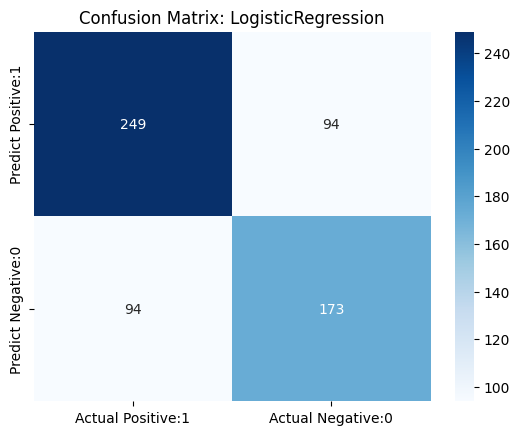


Model: LogisticRegression
AUC: 0.6869 (95% CI: 0.6509–0.7237)
F1 Score: 0.6479


In [9]:
log_reg_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    C=0.01,
    l1_ratio=0.0,
    random_state=42,
    max_iter=10000
)

log_reg_results = train_tuned_model(
    model=log_reg_model,
    X=X,
    y=y,
    cmap="Blues",
    scale=True
)

#### Gaussian Naive Bayes 

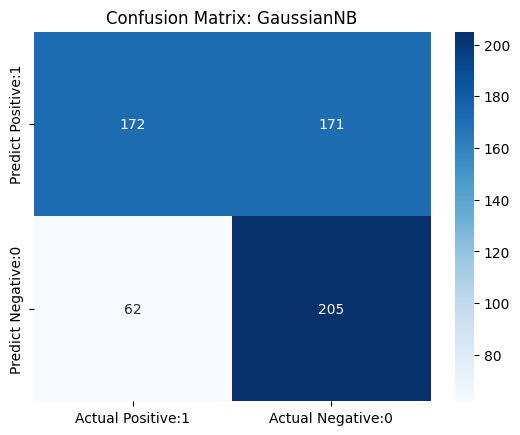


Model: GaussianNB
AUC: 0.6346 (95% CI: 0.5999–0.6703)
F1 Score: 0.6376


In [10]:
gaussiannb_model = GaussianNB(
    var_smoothing=0.01
)
gaussiannb_results = train_tuned_model(
    model=gaussiannb_model,
    X=X,
    y=y,
    cmap="Blues",
    scale=True
)

#### Support Vector Machines 

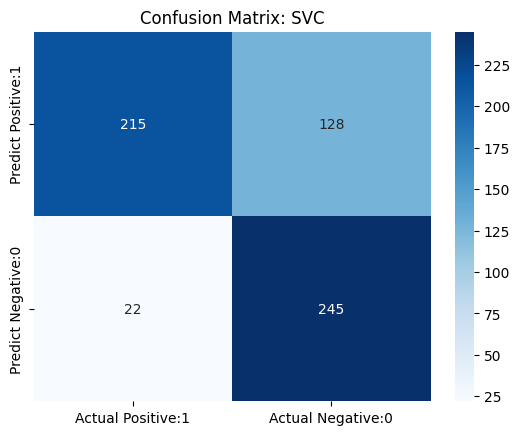


Model: SVC
AUC: 0.7722 (95% CI: 0.7403–0.8012)
F1 Score: 0.7656


In [11]:
svm_model = SVC(
    kernel='rbf', 
    C=1, 
    gamma='scale'
)
svm_results = train_tuned_model(
    model=svm_model,
    X=X,
    y=y,
    cmap="Blues",
    scale=True
)

#### Random Forests

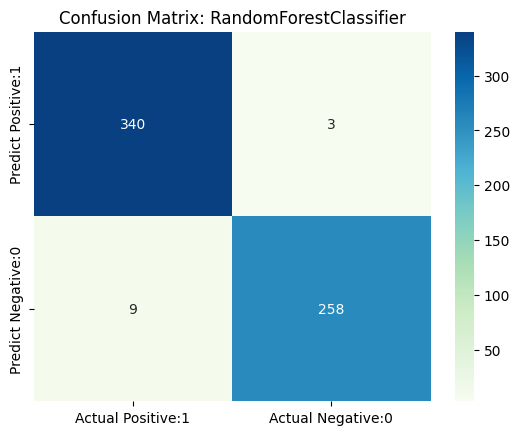


Model: RandomForestClassifier
AUC: 0.9788 (95% CI: 0.9656–0.9896)
F1 Score: 0.9773


In [12]:
rf_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=20, 
    min_samples_split=5, 
    min_samples_leaf=1
)
rf_results = train_tuned_model(
    model=rf_model,
    X=X,
    y=y,
    cmap="GnBu",
    scale=True
)

#### XGBoost

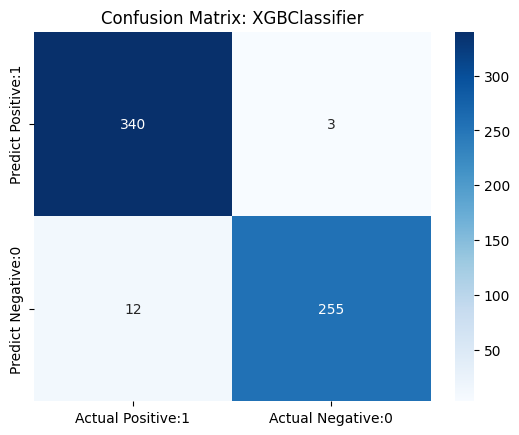


Model: XGBClassifier
AUC: 0.9732 (95% CI: 0.9582–0.9852)
F1 Score: 0.9714


In [13]:
xgb_model = XGBClassifier(
     n_estimators=100, 
     max_depth=6, 
     learning_rate=0.1, 
     subsample=1.0, 
     colsample_bytree=0.8
)
xgb_results = train_tuned_model(
    model=xgb_model,
    X=X,
    y=y,
    cmap="Blues",
    scale=True
)

## Train Best Model Instance on Whole Dataset

In [57]:
def train_final_model(model, X, y, save_path, scale=True):
    """
    Train model instance with hyperparameters.
    Save best model instance in provided path.
    """

    # optional global scaling
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # fit on all available data
    model.fit(X, y)

    # persist
    folder = os.path.dirname(save_path)
    if folder:
        os.makedirs(folder, exist_ok=True)
    joblib.dump(model, save_path)
    print(f"Final model trained on all data and saved to {save_path}")

    return model

In [59]:
save_path = '/home/user_stel/AIMB/model analysis/winner_model.pkl'
train_final_model(model=rf_model, 
                  X=X, 
                  y=y, 
                  save_path=save_path, 
                  scale=True)

Final model trained on all data and saved to /home/user_stel/AIMB/model analysis/winner_model.pkl


RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200)

# Plots 

In [18]:
results_list = [
    {"Model": "LR", "F1 Score": log_reg_results["F1 Score"]},
    {"Model": "GNB", "F1 Score": gaussiannb_results["F1 Score"]},
    {"Model": "SVM", "F1 Score": svm_results["F1 Score"]},
    {"Model": "RF", "F1 Score": rf_results["F1 Score"]},
    {"Model": "XGB", "F1 Score": xgb_results["F1 Score"]}
]

df_f1 = pd.DataFrame(results_list)
df_f1 = df_f1.sort_values("F1 Score", ascending=False)

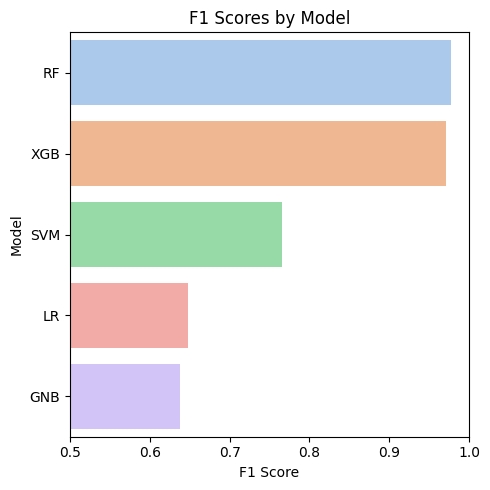

In [ ]:
# F1 score plot 
plt.figure(figsize=(5, 5))
sns.barplot(data=df_f1, x="F1 Score", y="Model", palette="pastel")

plt.title("F1 Scores by Model")
plt.xlabel("F1 Score")
plt.ylabel("Model")
plt.xlim(0.5, 1)
plt.tight_layout()
plt.show()
